# DQA and HVA combined for Heisenberg Hamiltonian
- odd nq
- obc and pbc

In [1]:
using PauliPropagation
using ReverseDiff
using ReverseDiff: GradientTape, compile, gradient!
using Distributions: Uniform
using Plots
using NLopt
using Random

In [18]:
# ──────────────────────────────────────────────────────────────
# 2. Néel state overlap
# ──────────────────────────────────────────────────────────────
function neel_bits(nq::Int; up_on_odd::Bool=true)
    if up_on_odd
        return collect(2:2:nq)
    else
        return collect(1:2:nq)
    end
end

function overlapwithneel(operator, nq::Int; up_on_odd::Bool=true)
    nb = neel_bits(nq; up_on_odd=up_on_odd)
    return overlapwithcomputational(operator, nb)
end

# ──────────────────────────────────────────────────────────────
# 3. HVA circuit construction
# ──────────────────────────────────────────────────────────────

function build_HVA_circuit(nq::Int, nl::Int; topology=nothing)
    circuit = Gate[]
    if topology === nothing
        topology = bricklayertopology(nq; periodic=false)
    end
    for _ in 1:nl
        rxxlayer!(circuit, topology)
        ryylayer!(circuit, topology)
        rzzlayer!(circuit, topology)
    end
    return circuit
end

# ──────────────────────────────────────────────────────────────
# 4. Loss function for optimization
# ──────────────────────────────────────────────────────────────
function HVA_loss(thetas::AbstractVector, circuit, nq;
    topology=nothing, max_freq=Inf, max_weight=Inf)
    if isnothing(topology)
        topology = bricklayertopology(nq; periodic=false)
    end

    CoeffType = eltype(thetas)
    H = PauliSum(CoeffType, nq)
    for pair in topology
        add!(H, [:X, :X], collect(pair), CoeffType(1.0))
        add!(H, [:Y, :Y], collect(pair), CoeffType(1.0))
        add!(H, [:Z, :Z], collect(pair), CoeffType(1.0))
    end

    wrapped_H = wrapcoefficients(H, PauliFreqTracker)
    propagated = propagate!(circuit, wrapped_H, thetas; max_freq, max_weight) 
    return overlapwithneel(propagated, nq)
end

# ──────────────────────────────────────────────────────────────
# 5. Optimizers: Adam, LBFGS
# ──────────────────────────────────────────────────────────────
function adam_optimizer(thetas_init, lossfun, nq; eta=0.02, steps=150)
    tape = GradientTape(lossfun, thetas_init)
    compile(tape)
    grad = similar(thetas_init)
    thetas = copy(thetas_init)
    opt_energy = Float64[]

    m = zero(thetas)
    v = zero(thetas)
    β1, β2, ϵ = 0.9, 0.999, 1e-8

    for t in 1:steps
        gradient!(grad, tape, thetas)
        m .= β1 .* m .+ (1 - β1) .* grad
        v .= β2 .* v .+ (1 - β2) .* (grad .^ 2)
        m̂ = m ./ (1 - β1^t)
        v̂ = v ./ (1 - β2^t)
        thetas .-= eta .* m̂ ./ (sqrt.(v̂) .+ ϵ)
        push!(opt_energy, lossfun(thetas) / nq)
    end
    return thetas, opt_energy
end

function lbfgs_optimizer(thetas_init, lossfun, nq; max_iters=300)
    n = length(thetas_init)
    tape = GradientTape(lossfun, thetas_init)
    compile(tape)
    gradbuf = zeros(n)
    opt = NLopt.Opt(:LD_LBFGS, n)
    NLopt.maxeval!(opt, max_iters)

    opt_energy = Float64[]
    NLopt.min_objective!(opt, (x, grad) -> begin
        fx = lossfun(x)::Float64
        if !isempty(grad)
            gradient!(gradbuf, tape, x)
            grad .= gradbuf
        end
        push!(opt_energy, fx)
        return fx
    end)
    minf, thetas, ret = NLopt.optimize(opt, thetas_init)
    return thetas, opt_energy ./ nq
end

# ──────────────────────────────────────────────────────────────
# 6. Interpolation circuit for digitized quantum annealing (DQA) 
#    Goes from ZZ-driver to Heisenberg --> we are in the odd 
#    symmetry sector
# ──────────────────────────────────────────────────────────────

function heisenberg_interpolation_circuit(nq, P; del_t= 0.1, J=1.0, hbar=1.0, topology=nothing, periodic = false) 
    tau = del_t * P # tau is total annealing time, divided into P steps/layers of circuit
    if topology === nothing
        topology = bricklayertopology(nq; periodic=periodic)
    end
    circuit = heisenbergtrottercircuit(nq, P;topology=topology)
    periodic ? nbonds = nq : nbonds = nq - 1 # if periodic nq bonds, else nq-1 (1d chain)
    total = P * (3*nbonds)
    params  = Vector{Float64}(undef, total)
    idx = 1

    for m in 1:P # layers of trotterized circuit
        s_m = (m - 0.5) / P
        beta   = J * del_t / hbar    # ZZ coefficient
        gamma  =  J * s_m       * del_t / hbar     # XX/YY coefficient
        θZZ = 2*beta
        θXX = 2*gamma
        θYY = 2*gamma
    
        @inbounds fill!(view(params, idx:idx+nbonds-1), θXX);             idx += nbonds
        #println(params)
        @inbounds fill!(view(params, idx:idx+nbonds-1), θYY);             idx += nbonds
        #println(params)
        @inbounds fill!(view(params, idx:idx+nbonds-1), θZZ);             idx += nbonds
        #println(params)
    end

    circuit= freeze(circuit, params)
    return circuit
end



# ──────────────────────────────────────────────────────────────
# 7. Run HVA optimization
# ──────────────────────────────────────────────────────────────
function run_HVA(nq::Int=3; nl::Int=2, opt::Symbol=:adam, interpol_circ=nothing, verbose=true, max_freq=Inf, max_weight=Inf, steps=150)
    circuit = build_HVA_circuit(nq, nl)
    nparams = length(circuit)
    thetas_init = rand(Uniform(-0.1, 0.1), nparams)

    if interpol_circ!= nothing
        append!(circuit, interpol_circ)
    end
    
    # tie closure for differentiation
    closed_loss = let const_circ = circuit, const_nq = nq, const_max_freq=max_freq, const_max_weight=max_weight
        θ -> HVA_loss(θ, const_circ, const_nq; max_freq=const_max_freq, max_weight=const_max_weight)
    end

    if opt == :adam
        thetas, E = adam_optimizer(thetas_init, closed_loss, nq; steps=steps)
    elseif opt == :lbfgs
        thetas, E = lbfgs_optimizer(thetas_init, closed_loss, nq)
    else
        error("Unknown optimizer $opt")
    end

    if verbose
        println("Final energy per qubit = $(E[end])")
        plot(E, marker=:o, xlabel="Iteration", ylabel="E/Q", title="HVA optimization ($opt)")
        display(current())
    end
    return thetas, E
end

run_HVA (generic function with 2 methods)

Final energy per qubit = -1.537181831075341


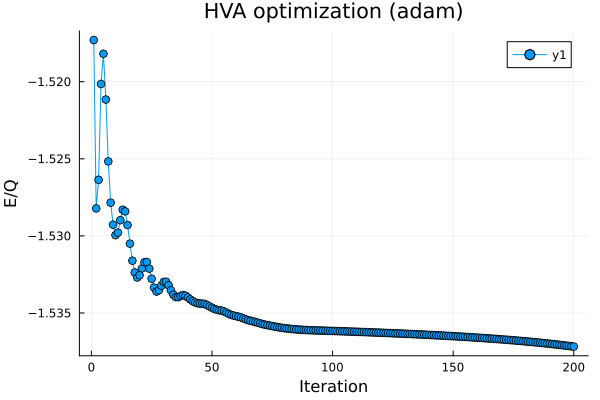

([0.22396217035977325, -0.0509151220271919, -0.23687768797075556, -0.10523480094413687, -0.07278937390469231, 0.14885238713339166, 0.10114638093562289, -0.1529510802064037, 0.6400429662282635, -0.5731763710980541  …  0.09139010593657329, 0.4210300345654133, -0.10085032334954742, -0.019915674971662564, -0.10336823668981307, -0.0030162284999909936, -0.39774030838282753, 0.009280278718626004, -0.17212797506275465, -0.2747236327626613], [-1.517297973912941, -1.5282190174977235, -1.5263638095421173, -1.5201452330831384, -1.5181890745761413, -1.521156585117072, -1.525168688591887, -1.527846228671547, -1.5292752438403772, -1.5299532348616875  …  -1.537014510928215, -1.5370320034249276, -1.537049797688826, -1.53706788642254, -1.5370862596450021, -1.5371049044484555, -1.5371238048372482, -1.5371429415856812, -1.5371622922017256, -1.537181831075341])

In [20]:
# test run
nq = 5
nl =3# layers of HVA
P = 1000 # steps for interpolation circuit to reach the target Hamiltonian
interpol_circ = heisenberg_interpolation_circuit(nq,P)
thetas, E = run_HVA(nq; nl=nl, opt=:adam, interpol_circ=interpol_circ, verbose=true, max_weight=10, steps = 200)